In [1]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
# Зададим размер батча для тренировки и тестирования сети
batch_size = 64
test_batch_size = 8

# Зададим необходимо количсетво эпох обучения
n_epochs = 2

# Задаем интервал логирования (количество батчей)
log_interval = 100

# Количество выходных классов (10 цифр)
num_classes = 10

# Зададим используемое для обучение устройство
device = torch.device("cpu")

In [3]:
# Предварительно вычисленные среднее и стандартное отколенение для датасета
data_mean = 0.131
data_std = 0.308

# Конвертируем входные изображения в тензоры и нормализуем их
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_mean,), (data_std,))
    ])

# Загружаем датасеты для тренировки и тестирования с применением трансформации
dtrain = datasets.MNIST('../data', train=True, download=True, transform=transform)
dtest = datasets.MNIST('../data', train=False, transform=transform)

# Задаем загружчики данных для обучения и тестирования
train_loader = torch.utils.data.DataLoader(dtrain,**{'batch_size': batch_size})
test_loader = torch.utils.data.DataLoader(dtest, **{'batch_size': test_batch_size})

In [4]:
# Задаем архитектуру нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.lin1(x)
        x = F.softmax(x, dim=1)
        return x

In [5]:
# Задаем типовой метод для обучения нейронной сети
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Эпоха обучения: {} [{}/{} ({:.0f}%)]\tПотери: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [6]:
# Задаем типовой метод для тестирования нейронной сети
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nТестовый набор данных: Средние потери: {:.5f}, Точность: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
# Передаем подготовленную модель на устройство (CPU)
model = Net().to(device)

In [8]:
optimizer = optim.Adadelta(model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.7)

# Обучаем модель
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

Эпоха обучения: 1 [0/60000 (0%)]	Потери: 2.299186
Эпоха обучения: 1 [6400/60000 (11%)]	Потери: 1.583359
Эпоха обучения: 1 [12800/60000 (21%)]	Потери: 1.602055
Эпоха обучения: 1 [19200/60000 (32%)]	Потери: 1.597460
Эпоха обучения: 1 [25600/60000 (43%)]	Потери: 1.568090
Эпоха обучения: 1 [32000/60000 (53%)]	Потери: 1.636874
Эпоха обучения: 1 [38400/60000 (64%)]	Потери: 1.550621
Эпоха обучения: 1 [44800/60000 (75%)]	Потери: 1.575868
Эпоха обучения: 1 [51200/60000 (85%)]	Потери: 1.603247
Эпоха обучения: 1 [57600/60000 (96%)]	Потери: 1.570279

Тестовый набор данных: Средние потери: -0.90175, Точность: 9127/10000 (91%)

Эпоха обучения: 2 [0/60000 (0%)]	Потери: 1.521993
Эпоха обучения: 2 [6400/60000 (11%)]	Потери: 1.534094
Эпоха обучения: 2 [12800/60000 (21%)]	Потери: 1.546375
Эпоха обучения: 2 [19200/60000 (32%)]	Потери: 1.569300
Эпоха обучения: 2 [25600/60000 (43%)]	Потери: 1.539039
Эпоха обучения: 2 [32000/60000 (53%)]	Потери: 1.623191
Эпоха обучения: 2 [38400/60000 (64%)]	Потери: 1.511379

In [19]:
print(dtrain.targets)

tensor([5, 0, 4,  ..., 5, 6, 8])


In [9]:
def tohex(val, nbits):
  return hex((val + (1 << nbits)) % (1 << nbits))
def print_array(A, bits):
    for i in A:
        if (len(A.shape) > 1):
            for j in i:
                print(tohex(j, bits)[2:].zfill(bits//4), end=" ")
            print()
        else:
            print(tohex(i, bits)[2:].zfill(bits//4), end=" ")

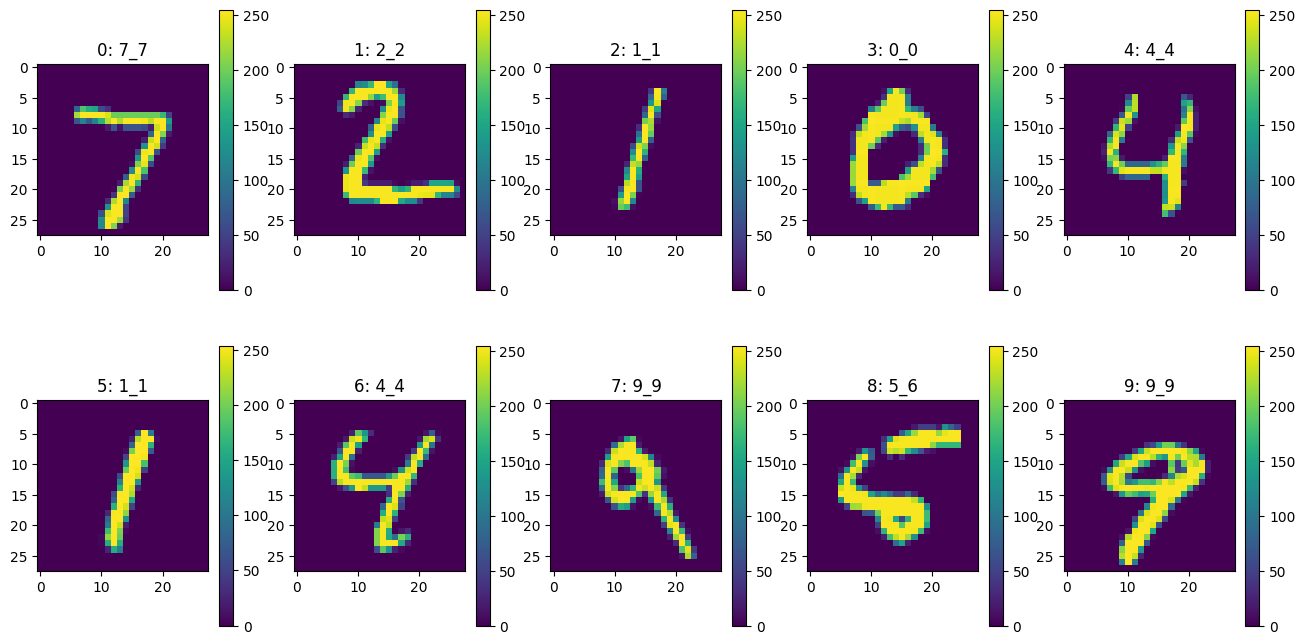

In [14]:
plt.figure(figsize=(16, 8))
for img in range(10):
  plt.subplot(2, 5, img+1)
  x_test = dtest.data[img, :, :]
  y_test = dtest.targets[img].detach().numpy()
  y_pred = model(dtest.data[img].to(torch.float32).to(device)).argmax().detach().numpy()
  plt.imshow(x_test)
  plt.title(str(img) + ": " + str(y_test) + "_" + str(y_pred))
  plt.colorbar()

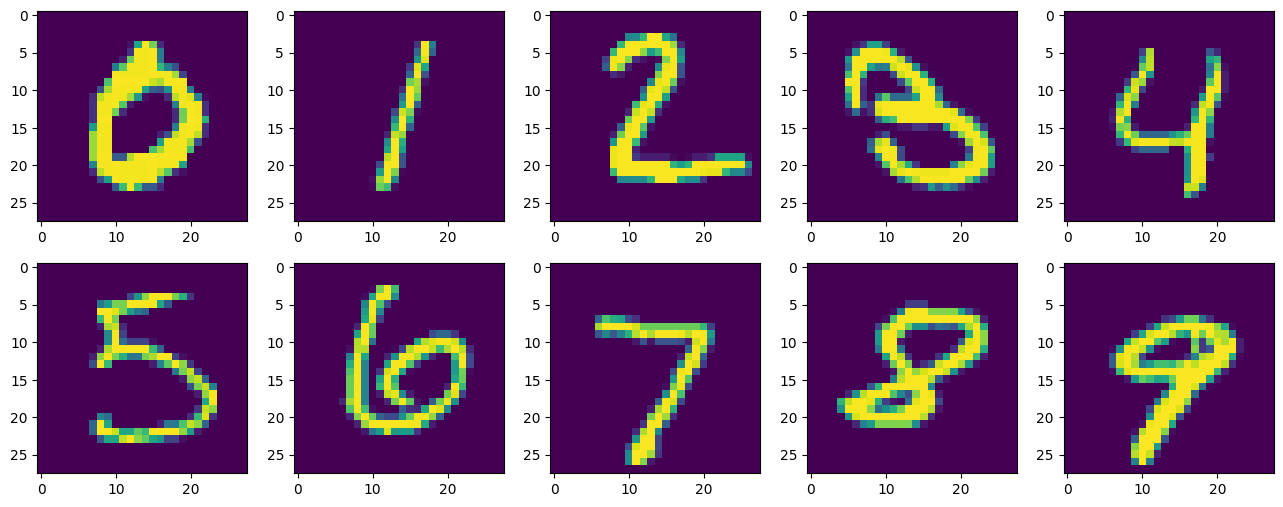

In [18]:
images = [3, 2, 1, 18, 4, 15, 11, 0, 61, 9]
plt.figure(figsize=(16, 6))
for i in range(len(images)):
  img = images[i]
  plt.subplot(2, 5, i+1)
  x_test = dtest.data[img, :, :]
  y_test = dtest.targets[img].detach().numpy()
  y_pred = model(dtest.data[img].to(torch.float32).to(device)).argmax().detach().numpy()
  plt.imshow(x_test)

In [ ]:
if save_model:
    torch.save(model.state_dict(), "mnist_cnn_pytorch.ckpt")

In [ ]:
def save(a, name):
    a = np.array(a) * 10000
    a = a.astype(np.int16)

    print('weight shape: ', a.shape)
    old_stdout = sys.stdout
    with open(name + ".txt", "w") as sys.stdout:
        for i in a:
            if (len(a.shape) > 1):
                for j in i:
                    print('{:d} '.format(j), end='')
                print()
            else:
                print('{:d} '.format(i), end='')
    sys.stdout = old_stdout

In [ ]:
print(model.lin1.bias.detach().numpy())
save(model.lin1.bias.detach().numpy(), "bias2")

[ 0.00099403 -0.07851407  0.01392994  0.03716532 -0.03272219  0.07787665
 -0.01547681 -0.02487389 -0.04032503 -0.02146326]
weight shape:  (10,)


In [ ]:
print(model.lin1.weight.detach().numpy().T)
save(model.lin1.weight.detach().numpy().T, "weight2")

[[ 0.02954763  0.00763043 -0.00072338 ...  0.0111871   0.00808979
  -0.01525778]
 [ 0.02049326 -0.00489414  0.02114862 ... -0.03603221  0.02808734
   0.01756463]
 [ 0.00668024  0.0034676  -0.02545485 ...  0.02595308  0.0174943
   0.0134935 ]
 ...
 [-0.02704675  0.05115715 -0.03875545 ... -0.03547022 -0.01756105
  -0.00819416]
 [ 0.03847111  0.05452135 -0.00284767 ... -0.02657634 -0.01970426
   0.0315943 ]
 [ 0.03703321  0.03688729  0.01084979 ...  0.03153852  0.0296776
   0.01894951]]
weight shape:  (784, 10)


In [ ]:
def read_save(name, transpose, bits):
    f = open(name + ".txt", "r")
    a = np.array([line.split() for line in f], dtype=np.float64)
    #print(np.amax(a))
    #a = a*(2**(data_width-1))/14600
    #print(np.amax(a))
    a = a.astype(np.int64)

    old_stdout = sys.stdout
    with open(name + ".hex.", "w") as sys.stdout:
        if (transpose):
            print_array(a.T, bits)
        else:
            print_array(a, bits)
    sys.stdout = old_stdout

read_save("weight2", False, 16)
read_save("bias2", False, 16)

In [ ]:
f = open("weight2.txt", "r")
w = np.array([line.split() for line in f], dtype=np.int64)

f = open("bias2.txt", "r")
b = np.array([line.split() for line in f], dtype=np.int64)

with open('images2.hex', 'r') as f:
    # Читаем содержимое файла в виде байтов
    for i in range(10):
        img = f.readline()
        img = np.array([int(b, 16) for b in img.split()], dtype=np.int16)
        print(np.matmul(img, w))
        res = np.matmul(img, w)+b
        print(res)
        print(np.argmax(res))
    
    f.close()

[ 10111360 -29616224 -10942140 -11113312 -23655448 -10670889  -8313626
 -12916062  -8351712 -15293599]
[[ 10111369 -29617009 -10942001 -11112941 -23655775 -10670111  -8313780
  -12916310  -8352115 -15293813]]
0
[-11380140   5385305   -519152  -2089665  -6338242  -7705830  -2846137
  -4946844    459590  -4799181]
[[-11380131   5384520   -519013  -2089294  -6338569  -7705052  -2846291
   -4947092    459187  -4799395]]
1
[  1280946 -11060552   9545578    273302 -26101846  -4711889   1700023
 -34650585   -792877 -22254945]
[[  1280955 -11061337   9545717    273673 -26102173  -4711111   1699869
  -34650833   -793280 -22255159]]
2
[-12704029 -12391589  -7907469  -1288170 -10558111 -12375227  -7211935
 -18804866  -6463566 -14421433]
[[-12704020 -12392374  -7907330  -1287799 -10558438 -12374449  -7212089
  -18805114  -6463969 -14421647]]
3
[ -5803234 -14891782  -7414419 -13382889   3905540 -12810529  -4271171
  -6925376  -2769581   -268039]
[[ -5803225 -14892567  -7414280 -13382518   3905213 -